In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
import keras.backend as K

In [27]:
# Load dataset
df = pd.read_csv('/kaggle/input/multilingual-datasets/final_datasets.csv')

# Clean data
for col in df.columns:
    if col not in ['age']:
        df[col] = df[col].fillna('unknown').astype(str)

df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['age'] = df['age'].fillna(df['age'].mean())
scaler = StandardScaler()
df['age'] = scaler.fit_transform(df[['age']])

# Create combined text
df['combined_text'] = df['gender'] + ' ' + df['age_bucket'] + ' ' + df['dominant_race'] + ' ' + df['dominant_emotion'] + ' ' + df['translated_text'] + ' ' + df['age'].astype(str)

# Labels
df['label'] = df['label'].astype(int)


In [28]:
# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['combined_text'])
sequences = tokenizer.texts_to_sequences(df['combined_text'])

# Pad sequences
max_len = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = df['label'].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
from tensorflow.keras.layers import Dropout, Dense, Bidirectional, LSTM, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the model architecture
input_layer = Input(shape=(max_len,))

# Embedding Layer
embedding = Embedding(input_dim=10000, output_dim=64)(input_layer)

# BiLSTM Layer
bilstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)

# Dropout Layer to prevent overfitting
dropout_1 = Dropout(0.5)(bilstm)

# Additional BiLSTM Layer for deeper learning
bilstm_2 = Bidirectional(LSTM(64))(dropout_1)

# Dense Layer with ReLU activation
dense_1 = Dense(128, activation='relu')(bilstm_2)

# Dropout for regularization
dropout_2 = Dropout(0.5)(dense_1)

# Final classification head (Dense layer for binary classification)
output_layer = Dense(1, activation='sigmoid')(dropout_2)

# Model definition
bilstm_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
bilstm_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Print model summary
bilstm_model.summary()

# Callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint("bilstm_model.keras", save_best_only=True, monitor="val_loss")
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 106)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 106, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 106, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 106, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 821,505 (3.13 MB)

 Trainable params: 821,505 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the model with callbacks
history = bilstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Epoch 1/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 73s 112ms/step - accuracy: 0.6803 - loss: 0.5977 - val_accuracy: 0.6987 - val_loss: 0.5614
Epoch 2/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 81s 110ms/step - accuracy: 0.7428 - loss: 0.4931 - val_accuracy: 0.7007 - val_loss: 0.5604
Epoch 3/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 62s 108ms/step - accuracy: 0.8057 - loss: 0.4107 - val_accuracy: 0.6973 - val_loss: 0.6023
Epoch 4/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 63s 109ms/step - accuracy: 0.8402 - loss: 0.3484 - val_accuracy: 0.6582 - val_loss: 0.7121
Epoch 5/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 63s 109ms/step - accuracy: 0.8679 - loss: 0.2951 - val_accuracy: 0.6680 - val_loss: 0.7989


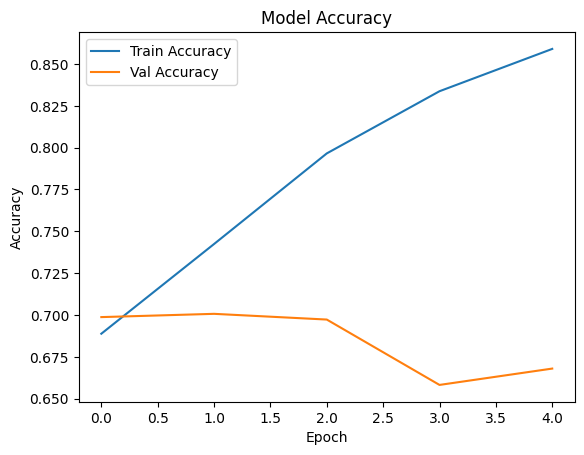

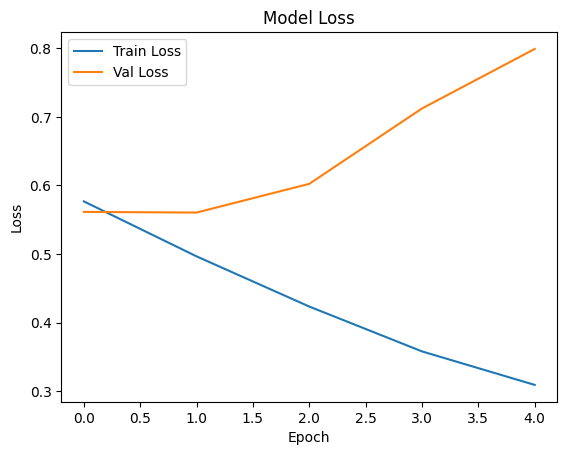

In [32]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
model = load_model("bilstm_model.keras")
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step


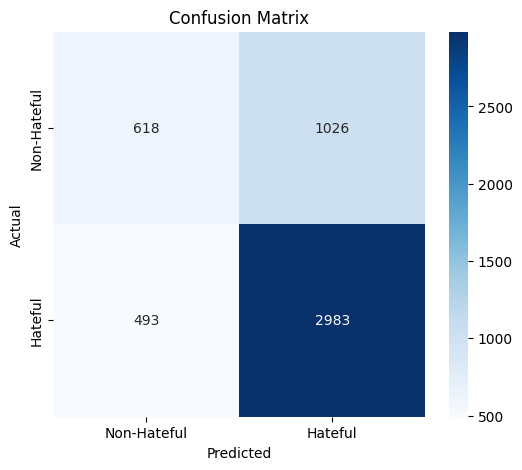

Classification Report:
              precision    recall  f1-score   support

 Non-Hateful       0.56      0.38      0.45      1644
     Hateful       0.74      0.86      0.80      3476

    accuracy                           0.70      5120
   macro avg       0.65      0.62      0.62      5120
weighted avg       0.68      0.70      0.69      5120



In [34]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hateful', 'Hateful'], yticklabels=['Non-Hateful', 'Hateful'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Hateful', 'Hateful']))

In [35]:
# Save the entire model (architecture + weights)
bilstm_model.save("bilstm_model.keras")